In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import mean
import torch
from torchvision import datasets, transforms, models
from torch.autograd import Variable

In [19]:
path='../input/soft-computing-even-id-dataset/training-a'


In [21]:
a_csv = pd.read_csv('../input/soft-computing-even-id-dataset/training-a.csv')
a_csv.columns
a_csv=a_csv.drop(columns=[s for s in a_csv.columns.to_list() if s !='filename' and s!='digit'])
# a_csv.iloc[:10, 0:]

In [22]:
label_csv = a_csv

In [23]:
import torch
from torch.utils import data as Dataset
from PIL import Image

class Datasets(Dataset.Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [24]:
mean = [0.5,]
std = [0.5, ]

train_transform = transforms.Compose([
    transforms.Resize(180),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
        transforms.Resize(180),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

train_dataset  = Datasets(label_csv, path, train_transform)
test_dataset = Datasets(label_csv, path, test_transform)


dataset_size = len(train_dataset)
indices = list(range(dataset_size))
train_dataset_len = int(np.floor(0.8 * dataset_size))
test_dataset_len = dataset_size - train_dataset_len
train_dataset, test_dataset = Dataset.random_split(train_dataset, lengths=[train_dataset_len, test_dataset_len])



In [25]:
batch_size = 20
num_iters = 20000
input_dim = 180*180 
num_hidden = 200  
output_dim = 10
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
learning_rate = 0.01  # More power so we can learn faster! previously it was 0.001

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)  

In [26]:
import torch.nn as nn
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        
        self.relu_1 = nn.ReLU()
 
        
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        
        self.relu_2 = nn.ReLU()
 
        
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        
        self.relu_3 = nn.ReLU()
 
         
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        
        self.relu_4 = nn.ReLU()
 
         
        self.linear_5= nn.Linear(num_hidden, num_hidden)
        
        self.relu_5= nn.ReLU()
 
         
        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        
        self.relu_6 = nn.ReLU()
 
        
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)
 
        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_3(out)
 
        out  = self.linear_4(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_4(out)
 
        out  = self.linear_5(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_5(out)
 
        out  = self.linear_6(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_6(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

In [27]:
model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)
 
# INSTANTIATE LOSS & OPTIMIZER CLASS
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
iteration=[]
lossList=[]
accuracyList=[]
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
 
        images = images.view(-1, 180*180).to(device)
        labels = labels.to(device)
 
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
 
        # Forward pass to get output/logits
        outputs = model(images) 
 
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
 
        # Getting gradients w.r.t. parameters
        loss.backward()
 
        # Updating parameters
        optimizer.step()
 
        iter += 1
 
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 180*180).to(device)
 
                # Forward pass only to get logits/output
                outputs = model(images)
 
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)
 
                # Total number of labels
                total += labels.size(0)
 
 
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()
 
            accuracy = 100 * correct.item() / total
 
            # Print Loss
#             iteration_loss.append(loss.item())
            iteration.append(iter)
            lossList.append(loss.item())
            accuracyList.append(accuracy)
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.3029379844665527. Accuracy: 10.048211113930474
Iteration: 1000. Loss: 2.300718307495117. Accuracy: 10.175082466379092
Iteration: 1500. Loss: 2.3001484870910645. Accuracy: 9.743719868053793
Iteration: 2000. Loss: 2.301642894744873. Accuracy: 9.667597056584624
Iteration: 2500. Loss: 2.2998435497283936. Accuracy: 14.031971580817052
Iteration: 3000. Loss: 2.2942872047424316. Accuracy: 10.022836843440752
Iteration: 3500. Loss: 2.2854132652282715. Accuracy: 14.590205531590966
Iteration: 4000. Loss: 2.2692275047302246. Accuracy: 15.021568129916265
Iteration: 4500. Loss: 2.188328266143799. Accuracy: 18.497843187008375
Iteration: 5000. Loss: 2.3232595920562744. Accuracy: 13.27074346612535
Iteration: 5500. Loss: 2.234052896499634. Accuracy: 12.484141080943923
Iteration: 6000. Loss: 2.0822482109069824. Accuracy: 19.79193098198427
Iteration: 6500. Loss: 2.2169532775878906. Accuracy: 17.05150976909414
Iteration: 7000. Loss: 1.9355428218841553. Accuracy: 16.341030195381883
It

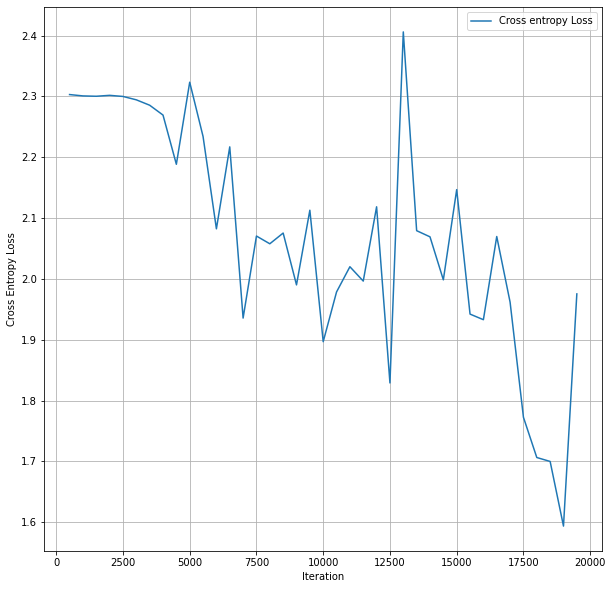

In [29]:
plt.figure(figsize=(10, 10))
plt.plot(iteration, lossList, label='Cross entropy Loss')
# plt.plot(iteration, accuracyList, label='Accuracy')
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration')
plt.legend()
plt.grid()
plt.show()

In [31]:
root_path ='./'
save_model = True

if save_model is True:
    # Saves only parameters
    # weights & biases
    torch.save(model.state_dict(), root_path + 'Assignment2_Experiment1.pkl') 

In [32]:
load_model = True

if load_model is True:
    model.load_state_dict(torch.load(root_path + 'Assignment2_Experiment1.pkl'))
    print('Trained Model Loaded')

Trained Model Loaded


In [35]:
import torch.nn as nn
class DeepNeuralNetworkModel2(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        
        self.relu_1 = nn.ReLU()
 
        
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        
        self.relu_2 = nn.ReLU()
 
        
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        
        self.relu_3 = nn.ReLU()
 
         
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        
        self.relu_4 = nn.ReLU()
 
         
        self.linear_5= nn.Linear(num_hidden, num_hidden)
        
        self.relu_5= nn.ReLU()
 
         
        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        
        self.relu_6 = nn.ReLU()
 
        
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)
 
        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_3(out)
 
        out  = self.linear_4(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_4(out)
 
        out  = self.linear_5(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_5(out)
 
        out  = self.linear_6(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_6(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas